In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Request 1
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Request 2
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [3]:
df = pd.read_csv('data_4.csv')

In [6]:
df

,Serviceid,Date,User_id,eWalletAges
0,20,2018-01-02,40709217,0
1,984,2018-03-22,18246539,10
2,269,2018-03-22,18246539,10
3,666,2018-04-01,18246539,10
4,326,2018-04-01,18246539,10
...,...,...,...,...
1431,268,2018-07-25,40722339,99
1432,269,2018-07-26,40722339,99
1433,984,2018-07-26,40722339,99
1434,333,2018-07-26,40722339,99


## 1. We would like to know whether users in different e-Wallet ages (e-Wallet ages = Last Service Date - First Service Date) have different serviceid cluster?


Step-by-step approach:
1. Check overall distribution of wallet ages.
2. Check overall data points to see the clusters.
3. Check detail on each groups.

## Check overall information

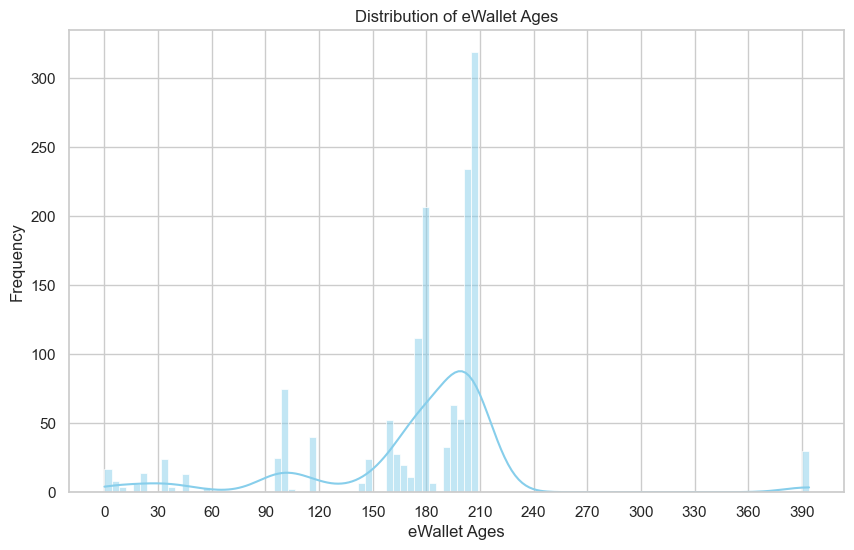

In [4]:
# Plotting using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='eWalletAges', bins=100, kde=True, color='skyblue')
plt.title('Distribution of eWallet Ages')

plt.xticks(range(0, int(df['eWalletAges'].max()) + 1, 30))
# plt.yticks(range(0, int(df['Serviceid'].max()) + 1, 200))
plt.xlabel('eWallet Ages')
plt.ylabel('Frequency')
plt.show()

## Plot data to see the relationship between eWalletAges & ServiceID

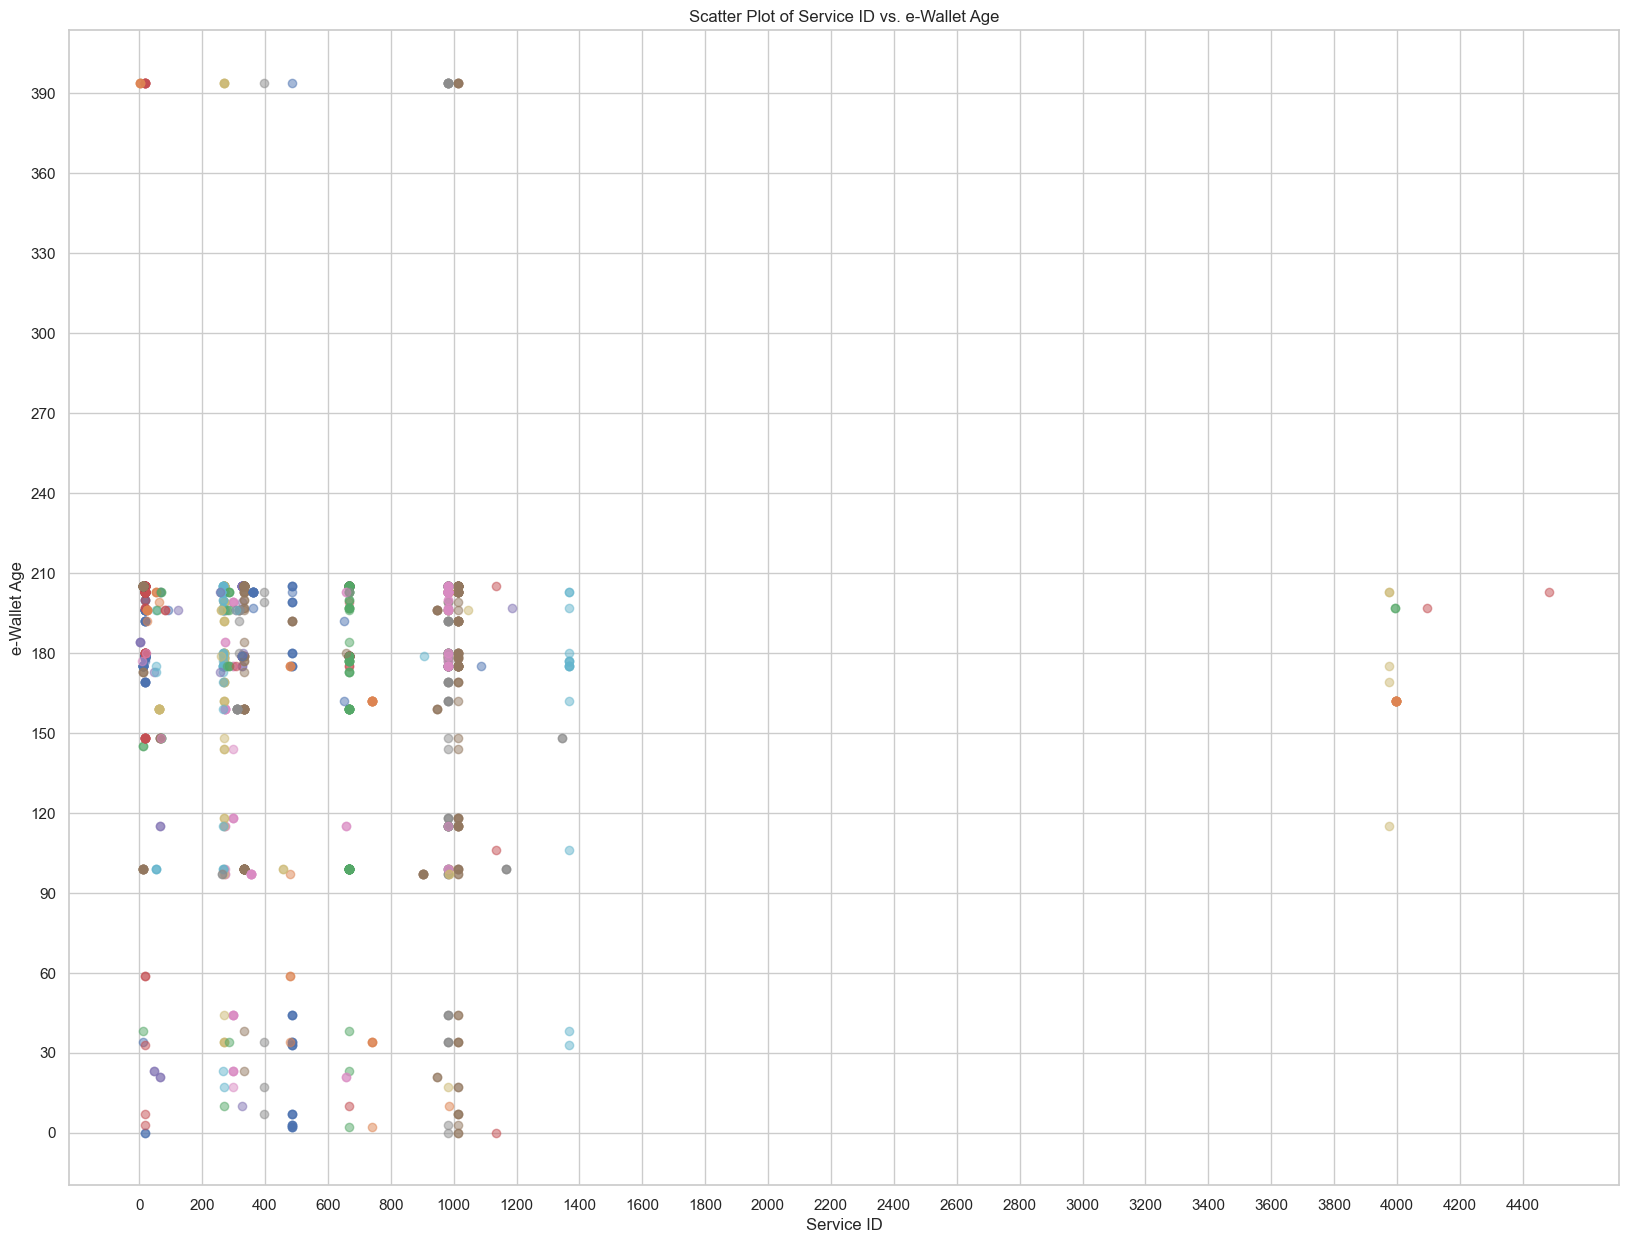

In [5]:
# Create scatter plot
plt.figure(figsize=(20, 15))
for service_id in df['Serviceid'].unique():
    service_data = df[df['Serviceid'] == service_id]
    plt.scatter(service_data['Serviceid'],service_data['eWalletAges'], alpha=0.5)

plt.yticks(range(0, int(df['eWalletAges'].max()) + 1, 30))
plt.xticks(range(0, int(df['Serviceid'].max()) + 1, 200))


# Add labels and title
plt.ylabel('e-Wallet Age')
plt.xlabel('Service ID')
plt.title('Scatter Plot of Service ID vs. e-Wallet Age')

# Add legend
# plt.legend()
plt.grid(True)


# Display plot
plt.show()


# ==> Insights 1: Overall cluster observation
- eWallet ages from 0-30days <> ServiceID 0-1200
- eWallet ages from 30-90days <> ServiceID 0-1400
- eWallet ages from 90-210days <> ServiceID 0-1400 & ServiceID 3800-4600
- eWallet ages from > 210days <> ServiceID 0-1200 


## Details: Heatmap

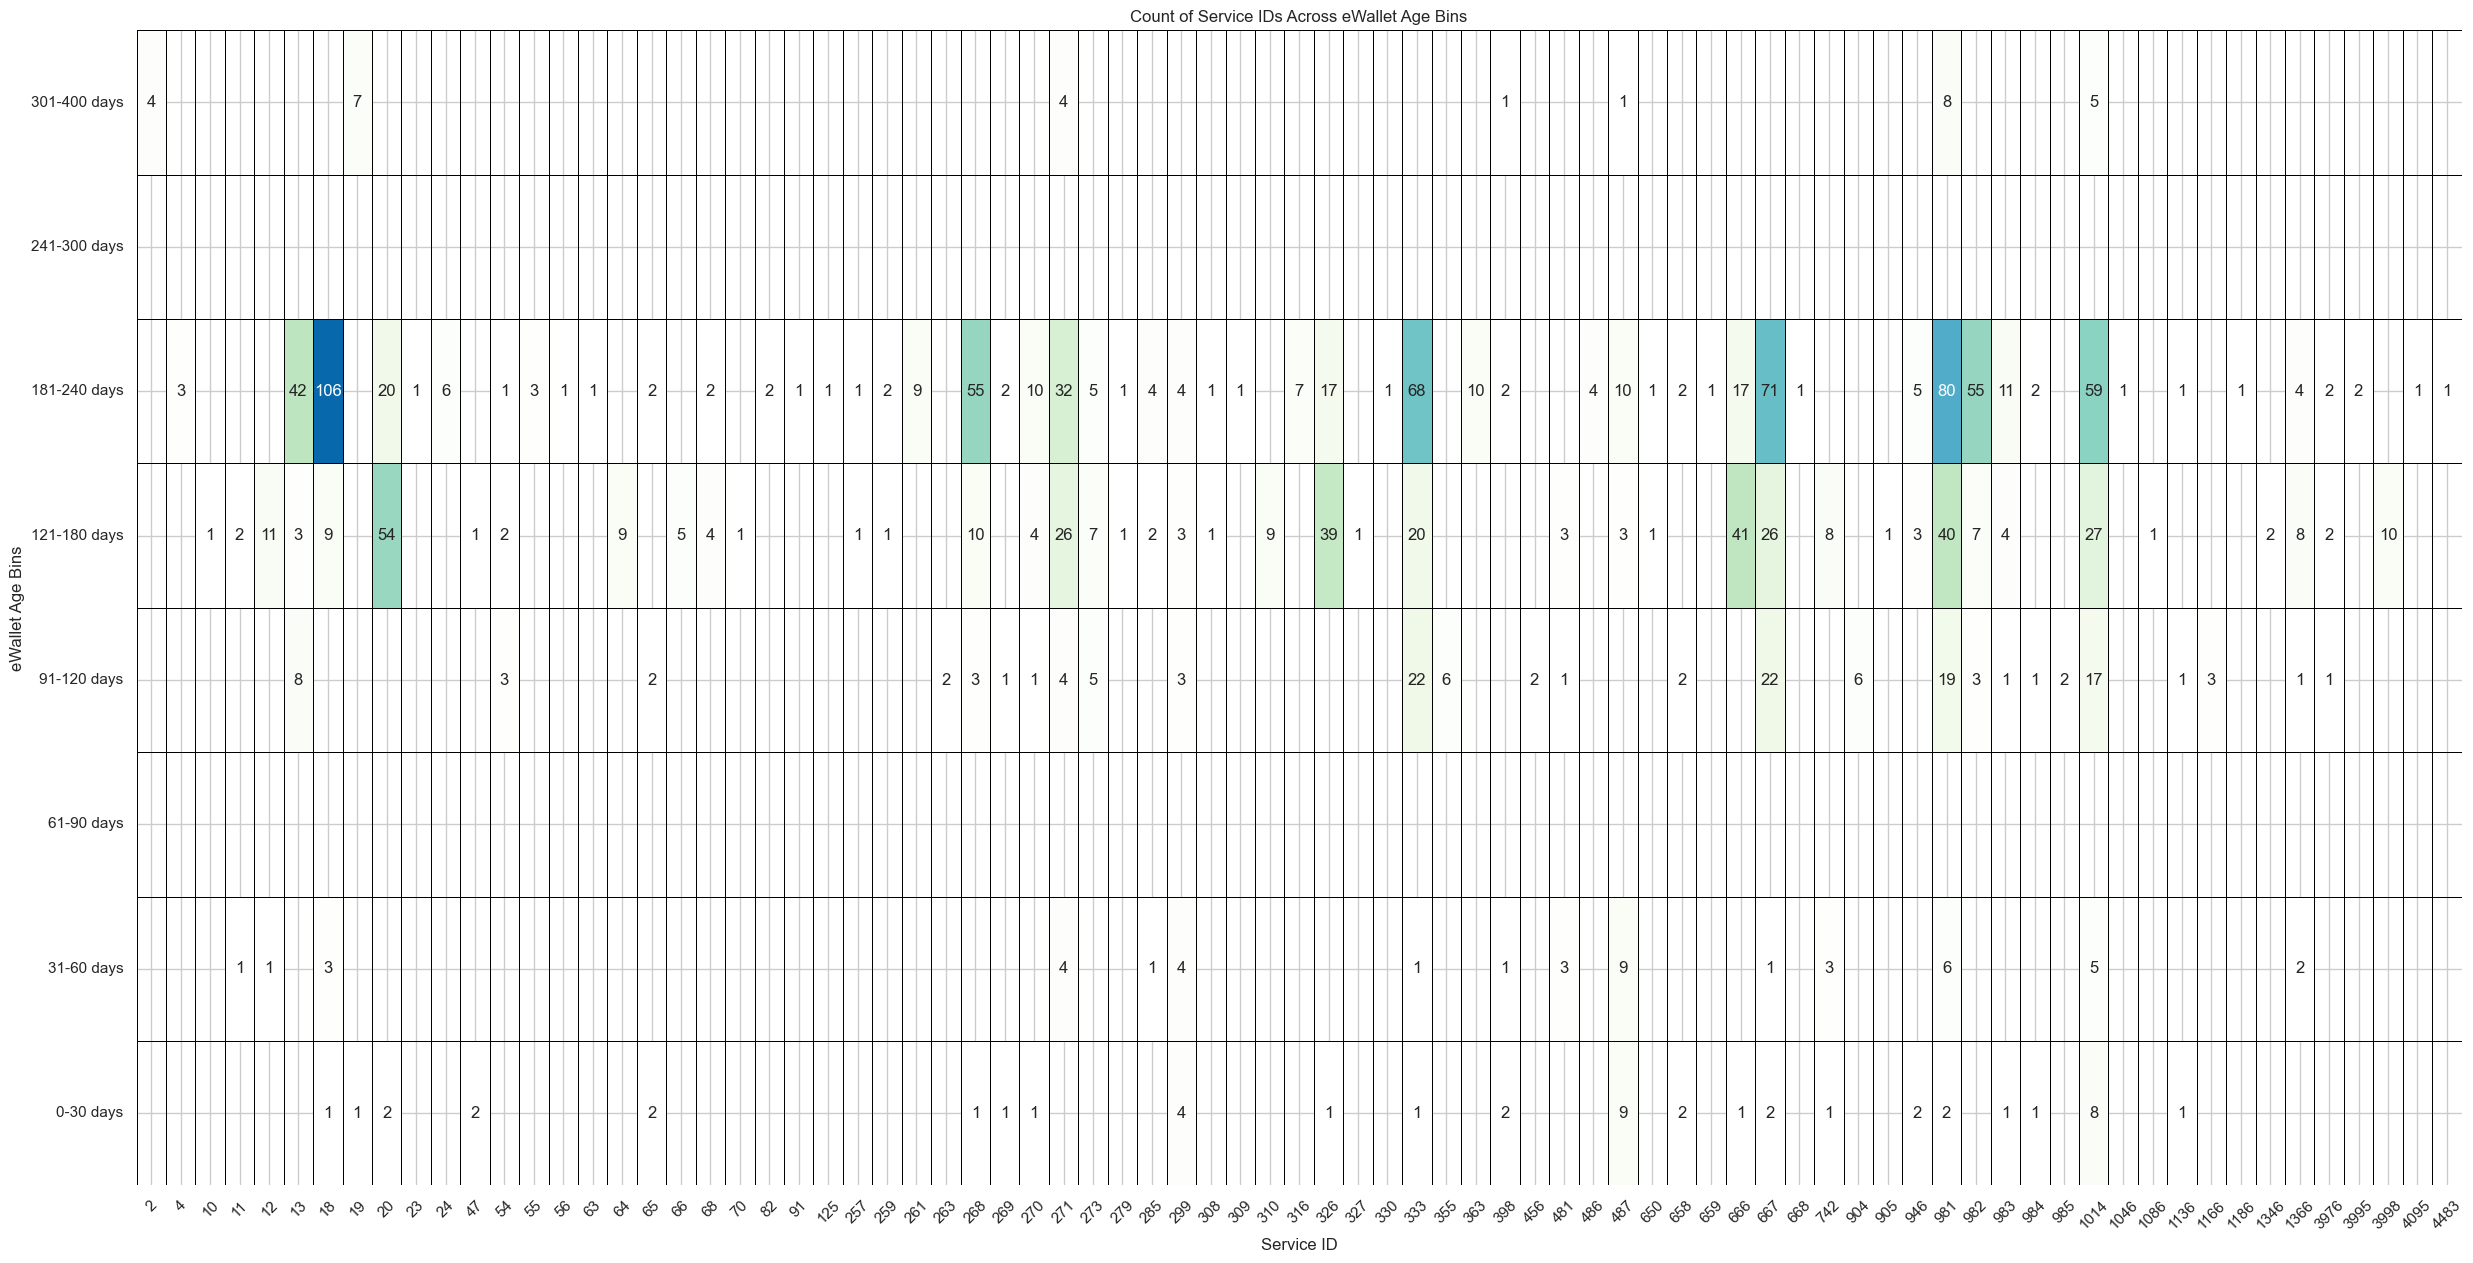

In [8]:
# Define custom colors for the heatmap
colors = ['#ffffff', '#f0f9e8', '#bae4bc', '#7bccc4', '#43a2ca', '#0868ac']  # Example colors

# Create a custom colormap using LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Group by eWalletBins and apply value_counts on ServiceID within each group
count_data = df.groupby('eWalletBins')['Serviceid'].value_counts().unstack(fill_value=0)

# Define the desired order for the y-axis (eWalletBins) and reverse it
desired_order = ['0-30 days', '31-60 days', '61-90 days', '91-120 days', '121-180 days', '181-240 days', '241-300 days', '301-400 days'][::-1]

# Reorder the index (eWalletBins) of count_data
count_data = count_data.reindex(desired_order)

# Plot the table map with custom colormap
plt.figure(figsize=(30, 15))
sns.heatmap(count_data, cmap=custom_cmap, annot=True, fmt="d", cbar=False, mask=(count_data == 0), linewidths=0.5, linecolor='black')
plt.title('Count of Service IDs Across eWallet Age Bins')
plt.xlabel('Service ID')
plt.ylabel('eWallet Age Bins')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


# ==> Insights 2: Compare details among the groups

For example: 0-30days vs 31-60days:
   - 0-30days has used ServiceID: 19,20,47,65,268,269,270,326, 658, 666, 946, 983, 984,1136 that 31-60days group has not used.
   - 31-60days has used ServiceID: 11,12, 271, 285, 481, 1366 that 0-30days group has not used.
   
=> Conclusion: Users in different e-Wallet ages have different serviceid cluster

## 2. We would like to know which serviceid we can cross-sales to users?

Approach:
1. Identify the requirement - Cross-sales = Market basket analysis
2. Choose the best method (apriori/fpgrowth)
3. (Optional) What services often bought together for each user?

In [7]:
df_2 = df[['Serviceid','User_id']].drop_duplicates()

In [8]:
df_2

,Serviceid,User_id
0,20,40709217
1,984,18246539
2,269,18246539
3,666,18246539
4,326,18246539
...,...,...
1385,1014,40722339
1386,981,40722339
1418,273,40722339
1432,269,40722339


In [9]:
# One-hot encode the dataset (convert it to a transactional format)
basket = df_2.groupby(['User_id', 'Serviceid']).size().unstack().fillna(0)

In [ ]:
# Apply Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

/Users/tiana/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
# Apply FP-Growth algorithm
frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)

/Users/tiana/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)


cross_selling_rules = rules[rules['lift'] > 1]

# Display the cross-selling rules
print("Cross-selling Opportunities:")
print(cross_selling_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


/Users/tiana/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


## What services often bought together for each user?

In [12]:
from itertools import combinations
from collections import Counter

count = Counter()

df_3 = df_2.copy()
df_3['User_id'] = df_3['User_id'].astype(str)
df_3['Serviceid'] = df_3['Serviceid'].astype(str)

df_3['Grouped'] = df_3.groupby('User_id')['Serviceid'].transform(lambda x: ','.join(x))
df_4 = df_3[['User_id','Grouped']].drop_duplicates()

for row in df_4['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

for key,value in count.most_common(100):
    print(key, value)

('1014', '271') 14
('1014', '981') 14
('981', '271') 13
('667', '333') 10
('981', '1014') 10
('1014', '270') 9
('1014', '983') 8
('667', '268') 8
('981', '982') 8
('981', '268') 8


## (Bonus) Any ideas that you want to analyze more with those data? 

##### 1. Service Usage Trends Over Time:
- Analyze how service usage varies over time to identify patterns and seasonality. For example, how does the usage of each service vary across different months or seasons?

##### 2. User Engagement Analysis:
- Calculate metrics like frequency of service usage and retention rate to understand user engagement. For example, do users tend to use multiple services regularly, or do they stick to their favorite ones?

##### 3. User Cohort Analysis:
- Group users by first usage date to analyze behavior differences between cohorts. For example, which service encourages users to engage initially?

##### 4. Customer Lifetime Value (CLV):
- Calculate CLV to identify high-value users and optimize acquisition and retention efforts. For example, who are our most loyal and dedicated users?

##### 5. Services Usage by Users:
- Identify which services are used the most or least by users. For example, which services are the most popular among users?